C2 의 센터를 찾는다.

In [1]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from tqdm import tqdm

from PIL import Image, ImageOps


In [2]:
DATA_DIR = "/Volumes/SSD970/"
SAGITTAL_LABEL_DIR = "/Volumes/SSD970/train_sagittal_labels_jpeg95/"

In [3]:
IMAGE_SIZE=256
LABEL_SCALE=32

In [4]:
def read_png_image(path):
    img = Image.open(path)
    return np.asarray(img)

In [5]:
def get_PatientUID(UID):
    return "1.2.826.0.1.3680043." + str(UID)

In [6]:
def read_sagittal_labels(UID, label_scale=256):
    PatientUID = get_PatientUID(UID)
    label_dir = os.path.join(SAGITTAL_LABEL_DIR, PatientUID)

    image_paths = glob.glob(label_dir + "/**")
    image_paths.sort(key=lambda x: int(x.split("/")[-1].replace(".png","")))

    imgs = np.zeros((len(image_paths), IMAGE_SIZE, IMAGE_SIZE))
    for i, path in enumerate(image_paths):
       np_img = read_png_image(path)
       imgs[i] = np_img

    return imgs / label_scale

imgs = read_sagittal_labels(9236)
print(imgs.max())
imgs.shape

0.109375


(376, 256, 256)

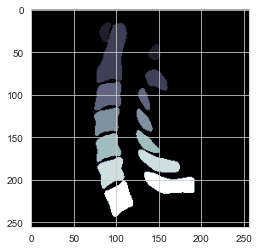

In [7]:
plt.imshow(imgs[189, :, :], cmap='bone')

In [8]:
def pick_spine(imgs, spine=2):
    spine_imgs = np.copy(imgs)
    spine_imgs[spine_imgs != (spine * 0.125)] = 0
    return spine_imgs

In [9]:
imgs = pick_spine(imgs, 2)
imgs.max()

0.0

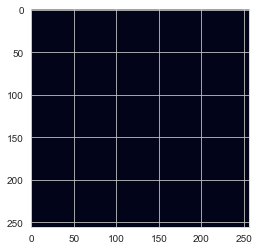

In [10]:
plt.imshow(imgs[256, :, :])

In [11]:
imgs.nonzero()

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

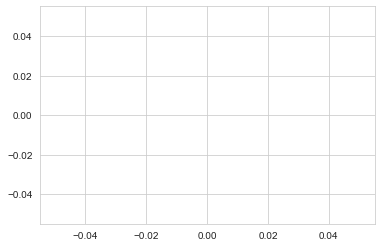

In [12]:
height, row, column = imgs.nonzero()
plt.plot(row)

In [13]:
len(height)

0

In [14]:
sorted_indice = row.argsort()
center_pos = sorted_indice[:100].mean()
center_pos

/var/folders/3l/2d1zfhx90z18_kvtkwwz9xtw0000gn/T/ipykernel_47507/2508122589.py:2: RuntimeWarning: Mean of empty slice.
  center_pos = sorted_indice[:100].mean()
/Users/longyikim/anaconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [ ]:
def find_center_slice(imgs):
    height, row, column = imgs.nonzero()
    sorted_indice = row.argsort()
    center_pos = sorted_indice[:100].mean()
    return height[int(center_pos)]



## Show sagittal center

In [ ]:
imgs = read_sagittal_labels(10051)
spine_imgs = pick_spine(imgs, 2)
center_slice = find_center_slice(spine_imgs)
print("center {}".format(center_slice))

plt.imshow(imgs[center_slice, :, :], cmap='bone')

## Final method

In [ ]:
def find_spine_center(UID, spine, label_scale=256):
    imgs = read_sagittal_labels(UID, label_scale)
    imgs = pick_spine(imgs, spine)
    center = find_center_slice(imgs)
    return center